# ![](https://ga-dash.s3.amazonaws.com/production/assets/logo-9f88ae6c9c3871690e33280fcf557f33.png) Project 4B - Social Impact

---

### <b> Notebook 4: Text processing & Modelling on Balanced MBTI dataset

Structure of this notebook </b>

* Part 1: Preparing the MBTI dataframe for text processing
* Part 2: Tokenization & Stemming
* Part 3: Using TF-IDF to vectorize the corpus
* Part 4: Modelling 
    * Logistic Regression
    * Bernoulli Naive Bayes
    * Multinomial Naive Bayes
    * SVC
    * Random Forest 
    * Forward Feed Neural Network
* Part 5: Model Evaluation


---

### Import Libraries

In [1]:
# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Preprocessing imports
import re
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV
import joblib

# Setting random seed for entire notebook
import random
random.seed(42)

### Part 1: Preparing the MBTI dataframe for text processing

(a) To import in the cleaned dataset

In [2]:
# Read the dataset
df_clean_mbti = pd.read_csv("./cleaned_data/final_balanced_cleaned_mbti.csv")

In [3]:
# Inspect the dataset
pd.set_option('display.max_colwidth', 40)
df_clean_mbti.head()

,type,processed_posts
0,INTJ,i tend to build up a collection of t...
1,ISTP,thanks pinina i initially wanted ham...
2,INFJ,every position world view spiritual ...
3,INFJ,my new boss is really annoying i rea...
4,INFJ,i love being infj except for these ...


(b) To split the MBTI traits into new columns and convert to Boolean

In [4]:
# S (Sensing) vs N (Intuition) - Related to information processing
# T (Thinking) vs F (Feeling) - Related to cognitive functions 
# J (Judging) vs P (Perception) - Linked to priortizing the cognitive functions 

# Instantiate 3 separate lists to contain the 3 separate traits respectively
list_sn = []
list_tf = []
list_jp = []

for mbti in df_clean_mbti["type"]:
    letters = list(mbti)
    list_sn.append(letters[1])
    list_tf.append(letters[2])
    list_jp.append(letters[3])

# Combine each of the list as a new column to the existing dataframe
df_clean_mbti["s_n"] = list_sn
df_clean_mbti["t_f"] = list_tf
df_clean_mbti["j_p"] = list_jp

# Checking the new df
df_clean_mbti.head()

,type,processed_posts,s_n,t_f,j_p
0,INTJ,i tend to build up a collection of t...,N,T,J
1,ISTP,thanks pinina i initially wanted ham...,S,T,P
2,INFJ,every position world view spiritual ...,N,F,J
3,INFJ,my new boss is really annoying i rea...,N,F,J
4,INFJ,i love being infj except for these ...,N,F,J


In [5]:
# Boolean the 3 new columns so that it can be used for modelling as the y variable
# S = 1, N = 0
# T = 1, F = 0
# J = 1, P = 0

df_clean_mbti["s_n"] = df_clean_mbti["s_n"].map({"S": 1, "N": 0})
df_clean_mbti["t_f"] = df_clean_mbti["t_f"].map({"T": 1, "F": 0})
df_clean_mbti["j_p"] = df_clean_mbti["j_p"].map({"J": 1, "P": 0})

df_clean_mbti.head()

,type,processed_posts,s_n,t_f,j_p
0,INTJ,i tend to build up a collection of t...,0,1,1
1,ISTP,thanks pinina i initially wanted ham...,1,1,0
2,INFJ,every position world view spiritual ...,0,0,1
3,INFJ,my new boss is really annoying i rea...,0,0,1
4,INFJ,i love being infj except for these ...,0,0,1


---

### Part 2: Tokenization & Stemming

As we have to use processed posts to evaluate 3 different traits, there is a need to create 3 different y variables (target) for modelling. We will be reiterating the tokenizing and stemming process to prepare for modelling for 3 different classifiers.

In [6]:
# Define X and y variables
X = df_clean_mbti[["processed_posts"]]

# Labelling y variables separately
y_sn = df_clean_mbti["s_n"] 
y_tf = df_clean_mbti["t_f"]
y_jp = df_clean_mbti["j_p"]

In [7]:
# Checking X variable
pd.set_option('display.max_colwidth', 800)
X.head(2)

,processed_posts
0,i tend to build up a collection of things on my desktop that i use frequently and then move them into a folder called 'everything' from there it get sorted into type and sub type i ike to collect odd objects even at work a lot of people would call it junk but i like to collect it old unused software ill take that off your hands i have a bunch of old adobe i think its quite normal i tend to only see my friends in real life every couple of months as said earlier some people just dont get it but the good ones do edit i mostly mean tolerate it where do we go when we sleep is dreaming another form of being awake how many more layers of this are there if any thoughts about sleep keep me up at night edit sometimes im too scared thanks i wish i was free to follow my interests as i desired i fe...
1,thanks pinina i initially wanted hammer but it was already taken topcat and his antics heh no i'm not dead and certainly with no stds this thread has gotten much more diverse than i remember hmm this thread has been quiet lately topcatlsdtsubakiretsu pinina let's shake things up a notch suggest the wackiest halloween costume possible i can't seem to quote pilot now coburn must have challenges to overcome we're quite hard to spot because we can be quite adaptable you have to catch us in our quiet moments good point i actually didn't account for the fact that she could turn against us while in that state xd well you got tha istp cool subtle badassery that's more than sufficient which thread member will have the longest rap sheet topcat which thread member is most likely to be a spy pilot...


In [8]:
# Checking y target
y_sn.head(2)

0    0
1    1
Name: s_n, dtype: int64

In [9]:
# Checking distribution of y target variable
print(y_sn.value_counts())
print(y_tf.value_counts())
print(y_jp.value_counts())


s_n
0    1200
1    1200
Name: count, dtype: int64
t_f
1    1200
0    1200
Name: count, dtype: int64
j_p
1    1200
0    1200
Name: count, dtype: int64


In [10]:
# # Define stemmer function which will tokenize and stem the corpus
def stemmer(row):
    '''Applies `PorterStemmer()` to each token in a document.
    '''
    # INstantiate stemmer
    stem = PorterStemmer()

    # Extracts post from each row
    document = row["processed_posts"]

    # Tokenize sentence using RegexpTokenizer
    re_tokenizer = RegexpTokenizer(pattern = r"(?u)\b(?:\w\w+|i|I)(?:[\'\'\′\ʼ](?:s|t|m|re|ve|d|ll))?\b")
    list_of_tokens = re_tokenizer.tokenize(document)

    # Applies stemmer to the list of tokens
    stemmed_document = ""
    for token in list_of_tokens:
        stemmed_document += f"{stem.stem(token)} "
    
    return stemmed_document

In [11]:
# Stem our corpus
X["processed_posts"] = X.apply(stemmer, axis = 1)

# Check output
pd.set_option("display.max_colwidth", 500)
X.head()

C:\Users\Admin\AppData\Local\Temp\ipykernel_22052\2855954937.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["processed_posts"] = X.apply(stemmer, axis = 1)


,processed_posts
0,i tend to build up collect of thing on my desktop that i use frequent and then move them into folder call everyth from there it get sort into type and sub type i ike to collect odd object even at work lot of peopl would call it junk but i like to collect it old unus softwar ill take that off your hand i have bunch of old adob i think it quit normal i tend to onli see my friend in real life everi coupl of month as said earlier some peopl just dont get it but the good one do edit i mostli mean...
1,thank pinina i initi want hammer but it wa alreadi taken topcat and hi antic heh no i'm not dead and certainli with no std thi thread ha gotten much more divers than i rememb hmm thi thread ha been quiet late topcatlsdtsubakiretsu pinina let' shake thing up notch suggest the wackiest halloween costum possibl i can't seem to quot pilot now coburn must have challeng to overcom we'r quit hard to spot becaus we can be quit adapt you have to catch us in our quiet moment good point i actual didn't...
2,everi posit world view spiritu outlook philosophi and religion are ultim human in natur they cater to human feel thought and desir you will alway be abl to identifi i don't know of ani infj chat room there is an intp one though on ecnet irc intp it' fairli activ it' not exactli what you'r look for but they have the in part so you'r half way there i have no chanc to describ thi without pictur so the blue is my right side on top and the red is my left then i do the same but on the other side w...
3,my new boss is realli annoy i realli want to leav work could someon pacifi her pl kitteh would an enfj be good match i found pictur onlin few week ago of the guy who use to bulli me when i wa younger on hi instagram profil and he now look like where' waldo and to be honest i still can't figur out sound like the worst pick up line ever or mayb the best do me favor go up to guy in bar and say that i'll bet he will buy you drink and then haha well you can never be wrong by give peopl nutella ri...
4,i love be infj except for these thing i wish i wa more social i can't initi convers i feel like i'm be nuisanc to whoever i want to talk to when i don't talk in hous burn notic white collar psych myth buster exclud hous they are not in ani particular order i'll give it shot will probabl remov these when if i come to my sens yea i know what you mean will do i'd feel bit bad do that but i'd feel way wors just ignor her thank for the advic will use it nah you'r not old style well if exactli wha...


In [12]:
# Check shape of df to ensure same number of rows after stemming
X["processed_posts"].shape

(2400,)

---

### Part 3: Using TF-IDF to vectorize the corpus

(a) Train Test Split the data

In [13]:
# Perform train test split data for 3 sets
X_train_sn, X_test_sn, y_train_sn, y_test_sn = train_test_split(X, y_sn, random_state = 42, stratify = y_sn)
X_train_tf, X_test_tf, y_train_tf, y_test_tf = train_test_split(X, y_tf, random_state = 42, stratify = y_tf)
X_train_jp, X_test_jp, y_train_jp, y_test_jp = train_test_split(X, y_jp, random_state = 42, stratify = y_jp)

In [14]:
# Checking number of cases for y_train
y_train_sn.value_counts()

s_n
1    900
0    900
Name: count, dtype: int64

In [15]:
# Checking number of cases for y_test
y_test_sn.value_counts()

s_n
0    300
1    300
Name: count, dtype: int64

(b) Vectorize the corpus

In [16]:
# Instantiate 'TF-IDF' vectorizer
tvec = TfidfVectorizer(stop_words = 'english',
                       token_pattern = r"(?u)\b(?:\w\w+|i|I)(?:[\'\’\′\ʼ](?:s|t|m|re|ve|d|ll))?\b",
                       ngram_range = (1, 3),
                       max_df = 0.9,
                       min_df = 0.1,
                       max_features = 50000)

In [17]:
# To attempt another combination of vectorizer 
tvec2 = TfidfVectorizer(stop_words = 'english',
                       token_pattern = r"(?u)\b(?:\w\w+|i|I)(?:[\'\’\′\ʼ](?:s|t|m|re|ve|d|ll))?\b",
                       ngram_range = (1, 3),
                       max_df = 0.9,
                       min_df = 0.3,
                       max_features = 50000)

In [18]:
# Testing out the effects of different tvecs
X_train_tvec_test = pd.DataFrame(tvec.fit_transform(X_train_sn["processed_posts"]).todense(),
                            columns = tvec.get_feature_names_out())
X_train_tvec_test.shape

(1800, 873)

In [19]:
# Testing out the effects of different tvecs
X_train_tvec_test2 = pd.DataFrame(tvec2.fit_transform(X_train_sn["processed_posts"]).todense(),
                            columns = tvec2.get_feature_names_out())
X_train_tvec_test2.shape

(1800, 209)

**Insights:**


As we have 3 sets of train test split data, we will have to repeat the vectorizing process 3 times for each set. We will also save the vectorizer as a .pkl file after every fitting as we will need it in Notebook 5 testing it on new data (Linkedin dataset). We have tried different variations of tvec by adjusting the min_df and we realised that resulted in  a drastic decrease in of columns (which means there are less features for our training data to train on) hence we will stick to min_df = 0.1.


#### 1. S-N Trait

In [20]:
# Fit transform train data
X_train_sn_tvec = pd.DataFrame(tvec.fit_transform(X_train_sn["processed_posts"]).todense(),
                            columns = tvec.get_feature_names_out())
X_train_sn_tvec.shape

(1800, 873)

In [21]:
# Transform test data
X_test_sn_tvec = pd.DataFrame(tvec.transform(X_test_sn["processed_posts"]).todense(),
                            columns=tvec.get_feature_names_out())
X_test_sn_tvec.shape

(600, 873)

In [22]:
# Saving the vectorizer as .pkl file for SN trait
joblib.dump(tvec, "./pkl_files/tvec_SN.pkl")

['./pkl_files/tvec_SN.pkl']

#### 2. T-F Trait

In [23]:
# Fit transform train data
X_train_tf_tvec = pd.DataFrame(tvec.fit_transform(X_train_tf["processed_posts"]).todense(),
                            columns = tvec.get_feature_names_out())
X_train_tf_tvec.shape

(1800, 865)

In [24]:
# Transform test data
X_test_tf_tvec = pd.DataFrame(tvec.transform(X_test_tf["processed_posts"]).todense(),
                            columns=tvec.get_feature_names_out())
X_test_tf_tvec.shape

(600, 865)

In [25]:
# Saving the vectorizer as .pkl file for TF trait
joblib.dump(tvec, "./pkl_files/tvec_TF.pkl")

['./pkl_files/tvec_TF.pkl']

#### 3. J-P Trait

In [26]:
# Fit transform train data
X_train_jp_tvec = pd.DataFrame(tvec.fit_transform(X_train_jp["processed_posts"]).todense(),
                            columns = tvec.get_feature_names_out())
X_train_jp_tvec.shape

(1800, 870)

In [27]:
# Transform test data
X_test_jp_tvec = pd.DataFrame(tvec.transform(X_test_jp["processed_posts"]).todense(),
                            columns=tvec.get_feature_names_out())
X_test_jp_tvec.shape

(600, 870)

In [28]:
# Saving the vectorizer as .pkl file for JP trait
joblib.dump(tvec, "./pkl_files/tvec_JP.pkl")

['./pkl_files/tvec_JP.pkl']

---

### Part 4: Modelling

In this section, we will attempt to use the following modelling algorithms to train the data.
* Logistic Regression
* Bernoulli Naive Bayes
* Multinomial Naive Bayes
* SVC
* Random Forest 
* Forward Feed Neural Network

In [29]:
# Modelling imports
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn import metrics

from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Dense, Dropout, InputLayer
from keras.regularizers import l1_l2
from sklearn.decomposition import PCA
from keras.callbacks import EarlyStopping

(a) Logistic Regression, Naive Bayes & SVC

In [30]:
# Make a pipeline to try the following models

logreg_pipe = Pipeline(steps = [("logreg", LogisticRegression())])
bnb_pipe = Pipeline(steps = [("bnb", BernoulliNB())])
mnb_pipe = Pipeline(steps = [("mnb", MultinomialNB())])
svc_pipe = Pipeline(steps = [("svc", SVC())])

classification_pipeline_list = [logreg_pipe, bnb_pipe, mnb_pipe, svc_pipe]

In [31]:
# Create a function that will calculate the scores and classification report based on pipeline list

def classify_model_scores(pipeline, x_train, y_train, x_test, y_test):
    list_all_scores = []

    for pipe in pipeline:
        # instantiate dictionary to fit in train score, test score, cross val score
        dict_scores = {}

        # fit the model into training data
        pipe.fit(x_train, y_train)


        # 1. get the r2 score for training data
        train_score = pipe.score(x_train, y_train)
        dict_scores["R2_train"] = train_score


        # 2. get the cross validation score 
        cross_validation = cross_val_score(pipe, x_train, y_train).mean()
        dict_scores["cross_val"] = cross_validation


        # 3. get the r2 score for testing data
        test_score = pipe.score(x_test, y_test)
        dict_scores["R2_test"] = test_score


        # 4. get the f1 scores
        # first create y_preds for training and testing data
        y_preds_train = pipe.predict(x_train)
        y_preds_test = pipe.predict(x_test)

        # 4a. F1 score of training data
        f1_train = metrics.f1_score(y_train, y_preds_train)
        dict_scores["training F1"] = f1_train
        
        # 4b. F1 score of testing data
        f1_test = metrics.f1_score(y_test, y_preds_test)
        dict_scores["testing F1"] = f1_test


        # 5. Append all scores into the list
        list_all_scores.append({pipe[0]: dict_scores})


        # 6. Print the classification report for testing data only
        report = classification_report(y_test, y_preds_test)
        print(f"{pipe}:")
        print(report)


    return list_all_scores

#### 1. S-N Trait Modelling Scores

In [32]:
classify_model_scores(classification_pipeline_list, X_train_sn_tvec, y_train_sn, X_test_sn_tvec, y_test_sn)

Pipeline(steps=[('logreg', LogisticRegression())]):
              precision    recall  f1-score   support

           0       0.88      0.89      0.88       300
           1       0.89      0.87      0.88       300

    accuracy                           0.88       600
   macro avg       0.88      0.88      0.88       600
weighted avg       0.88      0.88      0.88       600

Pipeline(steps=[('bnb', BernoulliNB())]):
              precision    recall  f1-score   support

           0       0.72      0.72      0.72       300
           1       0.72      0.72      0.72       300

    accuracy                           0.72       600
   macro avg       0.72      0.72      0.72       600
weighted avg       0.72      0.72      0.72       600

Pipeline(steps=[('mnb', MultinomialNB())]):
              precision    recall  f1-score   support

           0       0.86      0.85      0.85       300
           1       0.85      0.86      0.85       300

    accuracy                           0.85 

[{LogisticRegression(): {'R2_train': 0.9388888888888889,
   'cross_val': 0.8766666666666666,
   'R2_test': 0.8833333333333333,
   'training F1': 0.9392265193370165,
   'testing F1': 0.882154882154882}},
 {BernoulliNB(): {'R2_train': 0.7861111111111111,
   'cross_val': 0.7294444444444445,
   'R2_test': 0.72,
   'training F1': 0.7874102705687466,
   'testing F1': 0.72}},
 {MultinomialNB(): {'R2_train': 0.8738888888888889,
   'cross_val': 0.8272222222222222,
   'R2_test': 0.8516666666666667,
   'training F1': 0.8735376044568245,
   'testing F1': 0.8524046434494196}},
 {SVC(): {'R2_train': 0.9916666666666667,
   'cross_val': 0.9044444444444444,
   'R2_test': 0.9133333333333333,
   'training F1': 0.9916897506925207,
   'testing F1': 0.912751677852349}}]

#### 2. T-F Trait Modelling Scores

In [33]:
classify_model_scores(classification_pipeline_list, X_train_tf_tvec, y_train_tf, X_test_tf_tvec, y_test_tf)

Pipeline(steps=[('logreg', LogisticRegression())]):
              precision    recall  f1-score   support

           0       0.91      0.89      0.90       300
           1       0.89      0.92      0.90       300

    accuracy                           0.90       600
   macro avg       0.90      0.90      0.90       600
weighted avg       0.90      0.90      0.90       600

Pipeline(steps=[('bnb', BernoulliNB())]):
              precision    recall  f1-score   support

           0       0.74      0.77      0.75       300
           1       0.76      0.72      0.74       300

    accuracy                           0.75       600
   macro avg       0.75      0.75      0.75       600
weighted avg       0.75      0.75      0.75       600

Pipeline(steps=[('mnb', MultinomialNB())]):
              precision    recall  f1-score   support

           0       0.84      0.84      0.84       300
           1       0.84      0.84      0.84       300

    accuracy                           0.84 

[{LogisticRegression(): {'R2_train': 0.9311111111111111,
   'cross_val': 0.8833333333333332,
   'R2_test': 0.9033333333333333,
   'training F1': 0.9311111111111111,
   'testing F1': 0.9046052631578947}},
 {BernoulliNB(): {'R2_train': 0.7988888888888889,
   'cross_val': 0.7555555555555555,
   'R2_test': 0.7466666666666667,
   'training F1': 0.8017524644030667,
   'testing F1': 0.7406143344709898}},
 {MultinomialNB(): {'R2_train': 0.8661111111111112,
   'cross_val': 0.8311111111111111,
   'R2_test': 0.8416666666666667,
   'training F1': 0.8649859943977591,
   'testing F1': 0.8419301164725458}},
 {SVC(): {'R2_train': 0.99,
   'cross_val': 0.8916666666666668,
   'R2_test': 0.9166666666666666,
   'training F1': 0.9899665551839465,
   'testing F1': 0.9172185430463575}}]

#### 3. T-F Trait Modelling Scores

In [34]:
classify_model_scores(classification_pipeline_list, X_train_jp_tvec, y_train_jp, X_test_jp_tvec, y_test_jp)

Pipeline(steps=[('logreg', LogisticRegression())]):
              precision    recall  f1-score   support

           0       0.86      0.83      0.84       300
           1       0.84      0.86      0.85       300

    accuracy                           0.85       600
   macro avg       0.85      0.85      0.85       600
weighted avg       0.85      0.85      0.85       600

Pipeline(steps=[('bnb', BernoulliNB())]):
              precision    recall  f1-score   support

           0       0.67      0.68      0.67       300
           1       0.67      0.66      0.67       300

    accuracy                           0.67       600
   macro avg       0.67      0.67      0.67       600
weighted avg       0.67      0.67      0.67       600

Pipeline(steps=[('mnb', MultinomialNB())]):
              precision    recall  f1-score   support

           0       0.79      0.80      0.79       300
           1       0.80      0.79      0.79       300

    accuracy                           0.79 

[{LogisticRegression(): {'R2_train': 0.9172222222222223,
   'cross_val': 0.845,
   'R2_test': 0.8466666666666667,
   'training F1': 0.9164329781267527,
   'testing F1': 0.8486842105263157}},
 {BernoulliNB(): {'R2_train': 0.7344444444444445,
   'cross_val': 0.6477777777777777,
   'R2_test': 0.6683333333333333,
   'training F1': 0.7305524239007891,
   'testing F1': 0.665546218487395}},
 {MultinomialNB(): {'R2_train': 0.8355555555555556,
   'cross_val': 0.7805555555555556,
   'R2_test': 0.7933333333333333,
   'training F1': 0.8331454340473506,
   'testing F1': 0.7926421404682275}},
 {SVC(): {'R2_train': 0.9844444444444445,
   'cross_val': 0.8638888888888889,
   'R2_test': 0.865,
   'training F1': 0.9844444444444445,
   'testing F1': 0.8638655462184874}}]

(b) Random Forest

In [32]:
# Instantiate the random forest model
rf = RandomForestClassifier(random_state = 42)

from pprint import pprint
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [33]:
# Use randomized gridsearch cv to scout for the range of hyperparameters first using current settings above as a guide

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 400, num = 20)]  

# Number of features to consider at every split
max_features = ['log2', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 21)] # tried 1, 10; tried 10, 110
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 15, 20]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 3, 5, 7]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Summary of hyperparameters to test
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}


In [34]:
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid,
                              n_iter = 100, scoring = "r2", 
                              cv = 3, random_state = 42, n_jobs = -1)

# Fit the random search model
rf_random.fit(X_train_sn_tvec, y_train_sn);

In [35]:
# Get the best parameters and best score
best_score = rf_random.best_score_
best_parameters = rf_random.best_params_

print("Best Score: %s" % best_score)
print("Best Parameters: %s" % best_parameters)

Best Score: 0.49111111111111105
Best Parameters: {'n_estimators': 336, 'min_samples_split': 20, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'max_depth': 105, 'bootstrap': True}


(c) Forward Feed Neural Networks

In [36]:
# Convert MBTI types to categorical variables first for NN 
label_encoder = LabelEncoder()
df_clean_mbti["type_numeric"] = label_encoder.fit_transform(df_clean_mbti["type"])
mbti_labels = label_encoder.classes_

**Insights:**

As part of neural network modelling, we wil need to label encode our labels first to categorical variables. We would also need to ensure the fitting of our features to our model - this will be achieved by PCA to do dimension reduction. n_components is according to the shape of our X_train data after we fit the TF-IDF vectorizer in for each trait.

#### 1. S-N Trait training

In [37]:
pca = PCA(n_components = 873)
X_train_reduced = pca.fit_transform(X_train_sn_tvec)

In [38]:
# Redefining the model structure according to S-N for fitting 

nn_model_sn = Sequential([
    InputLayer(input_shape = (873,)),  
    Dense(64, activation = "relu"),
    Dense(1, activation = "sigmoid")  
])

# Compile the model with the correct settings
nn_model_sn.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["accuracy"])

# Implementing a regularization technique
early_stopping = EarlyStopping(monitor = "accuracy", patience = 3, mode = "max", restore_best_weights = True)

# Fit the model with the correctly shaped data
history = nn_model_sn.fit(X_train_reduced, y_train_sn,
                    epochs = 50,
                    batch_size =  128,
                    callbacks = [early_stopping])



Epoch 1/50


15/15 [==============================] - 1s 4ms/step - loss: 0.6933 - accuracy: 0.5094
Epoch 2/50
15/15 [==============================] - 0s 3ms/step - loss: 0.6799 - accuracy: 0.7500
Epoch 3/50
15/15 [==============================] - 0s 3ms/step - loss: 0.6672 - accuracy: 0.8533
Epoch 4/50
15/15 [==============================] - 0s 3ms/step - loss: 0.6521 - accuracy: 0.8867
Epoch 5/50
15/15 [==============================] - 0s 3ms/step - loss: 0.6329 - accuracy: 0.9039
Epoch 6/50
15/15 [==============================] - 0s 3ms/step - loss: 0.6096 - accuracy: 0.9067
Epoch 7/50
15/15 [==============================] - 0s 3ms/step - loss: 0.5823 - accuracy: 0.9067
Epoch 8/50
15/15 [==============================] - 0s 3ms/step - loss: 0.5524 - accuracy: 0.9094
Epoch 9/50
15/15 [==============================] - 0s 3ms/step - loss: 0.5209 - accuracy: 0.9150
Epoch 10/50
15/15 [==============================] - 0s 2ms/step - loss: 0.4890 - accuracy: 0.9161
Epoch 11/50
15/

In [39]:
# Model evaluation for S-N Trait

# Transform the test data with PCA
X_test_reduced = pca.transform(X_test_sn_tvec)

# Verify the shape to ensure it's correctly transformed
print(X_test_reduced.shape)  # This should output (number_of_test_samples, 873)

# Evaluate the model
test_loss, test_accuracy = nn_model_sn.evaluate(X_test_reduced, y_test_sn)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

(600, 873)
19/19 [==============================] - 0s 1ms/step - loss: 0.4498 - accuracy: 0.8317
Test Loss: 0.4498050808906555
Test Accuracy: 0.8316666483879089


**Insights:**

The SN trait model has achieved a test accuracy of approximately 83.3% and a test loss of 0.478. These results are promising and suggest that our model generalizes well to unseen data, maintaining a high level of accuracy outside of the training set.

#### 2. T-F Trait training

In [40]:
pca = PCA(n_components = 865)
X_train_reduced_tf = pca.fit_transform(X_train_tf_tvec)

In [41]:
# Redefining the model structure according to T-F for fitting 

nn_model_tf = Sequential([
    InputLayer(input_shape = (865,)),  
    Dense(64, activation = "relu"),
    Dense(1, activation = "sigmoid")  
])

# Compile the model with the correct settings
nn_model_tf.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["accuracy"])

# Implementing a regularization technique
early_stopping = EarlyStopping(monitor = "accuracy", patience = 3, mode = "max", restore_best_weights = True)

# Fit the model with the correctly shaped data
history = nn_model_tf.fit(X_train_reduced_tf, y_train_tf,
                    epochs = 50,
                    batch_size =  128,
                    callbacks = [early_stopping])

Epoch 1/50
15/15 [==============================] - 1s 3ms/step - loss: 0.6917 - accuracy: 0.5189
Epoch 2/50
15/15 [==============================] - 0s 4ms/step - loss: 0.6772 - accuracy: 0.7711
Epoch 3/50
15/15 [==============================] - 0s 3ms/step - loss: 0.6629 - accuracy: 0.8583
Epoch 4/50
15/15 [==============================] - 0s 3ms/step - loss: 0.6442 - accuracy: 0.9028
Epoch 5/50
15/15 [==============================] - 0s 3ms/step - loss: 0.6204 - accuracy: 0.9156
Epoch 6/50
15/15 [==============================] - 0s 3ms/step - loss: 0.5917 - accuracy: 0.9206
Epoch 7/50
15/15 [==============================] - 0s 3ms/step - loss: 0.5593 - accuracy: 0.9278
Epoch 8/50
15/15 [==============================] - 0s 3ms/step - loss: 0.5243 - accuracy: 0.9322
Epoch 9/50
15/15 [==============================] - 0s 3ms/step - loss: 0.4883 - accuracy: 0.9317
Epoch 10/50
15/15 [==============================] - 0s 3ms/step - loss: 0.4527 - accuracy: 0.9361
Epoch 11/50
15/15 [

In [42]:
# Model evaluation for T-F Trait

# Transform the test data with PCA
X_test_reduced_tf = pca.transform(X_test_tf_tvec)

# Verify the shape to ensure it's correctly transformed
print(X_test_reduced_tf.shape)  # This should output (number_of_test_samples, 865)

# Evaluate the model
test_loss, test_accuracy = nn_model_tf.evaluate(X_test_reduced_tf, y_test_tf)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

(600, 865)
19/19 [==============================] - 0s 2ms/step - loss: 0.3482 - accuracy: 0.8717
Test Loss: 0.3481904864311218
Test Accuracy: 0.871666669845581


**Insights:**

The TF trait model achieved a test loss of 0.385 and a test accuracy of 86.7%. These results are promising and suggest that our model generalizes well to unseen data, maintaining a high level of accuracy outside of the training set.

#### 3. J-P Trait Training

In [43]:
pca = PCA(n_components = 870)
X_train_reduced_jp = pca.fit_transform(X_train_jp_tvec)

In [44]:
# Redefining the model structure according to T-F for fitting 

nn_model_jp = Sequential([
    InputLayer(input_shape = (870,)),  
    Dense(64, activation = "relu"),
    Dense(1, activation = "sigmoid")  
])

# Compile the model with the correct settings
nn_model_jp.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["accuracy"])

# Implementing a regularization technique
early_stopping = EarlyStopping(monitor = "accuracy", patience = 3, mode = "max", restore_best_weights = True)

# Fit the model with the correctly shaped data
history = nn_model_jp.fit(X_train_reduced_jp, y_train_jp,
                    epochs = 50,
                    batch_size =  128,
                    callbacks = [early_stopping])

Epoch 1/50
15/15 [==============================] - 1s 3ms/step - loss: 0.6914 - accuracy: 0.5261
Epoch 2/50
15/15 [==============================] - 0s 3ms/step - loss: 0.6776 - accuracy: 0.7033
Epoch 3/50
15/15 [==============================] - 0s 3ms/step - loss: 0.6648 - accuracy: 0.7950
Epoch 4/50
15/15 [==============================] - 0s 3ms/step - loss: 0.6482 - accuracy: 0.8633
Epoch 5/50
15/15 [==============================] - 0s 3ms/step - loss: 0.6268 - accuracy: 0.9128
Epoch 6/50
15/15 [==============================] - 0s 3ms/step - loss: 0.6016 - accuracy: 0.9350
Epoch 7/50
15/15 [==============================] - 0s 3ms/step - loss: 0.5717 - accuracy: 0.9344
Epoch 8/50
15/15 [==============================] - 0s 3ms/step - loss: 0.5385 - accuracy: 0.9322
Epoch 9/50
15/15 [==============================] - 0s 3ms/step - loss: 0.5037 - accuracy: 0.9306


In [45]:
# Model evaluation for J-P Trait

# Transform the test data with PCA
X_test_reduced_jp = pca.transform(X_test_jp_tvec)

# Verify the shape to ensure it's correctly transformed
print(X_test_reduced_jp.shape)  # This should output (number_of_test_samples, 870)

# Evaluate the model
test_loss, test_accuracy = nn_model_jp.evaluate(X_test_reduced_jp, y_test_jp)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

(600, 870)
19/19 [==============================] - 0s 2ms/step - loss: 0.6159 - accuracy: 0.8283
Test Loss: 0.6159277558326721
Test Accuracy: 0.82833331823349


**Insights:**

The JP trait model achieved a test loss of 0.616 and a test accuracy of approximately 82.83%. These results are promising and suggest that our model generalizes well to unseen data, maintaining a high level of accuracy outside of the training set.

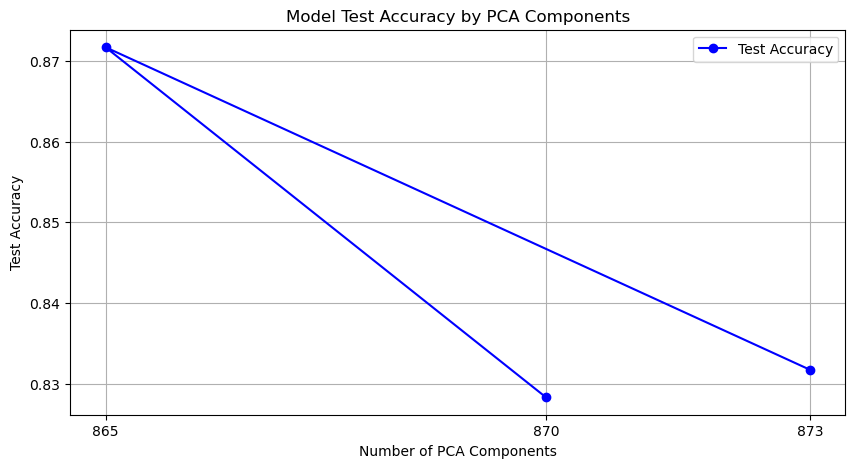

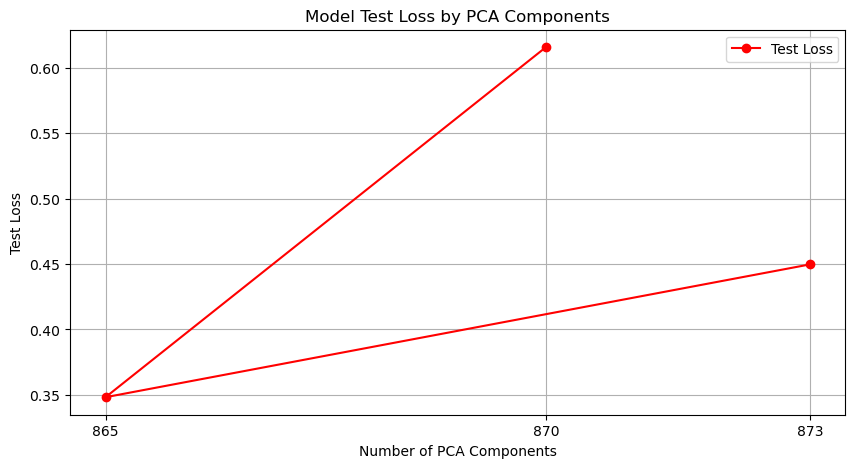

In [52]:
# Example data: Replace these lists with your actual data
pca_components = [873, 865, 870]  # Number of PCA components
test_accuracies = [0.8317, 0.8717, 0.8283]  # Corresponding test accuracies
test_losses = [0.4498, 0.3482, 0.6159]  # Corresponding test losses

# Plotting test accuracy
plt.figure(figsize=(10, 5))
plt.plot(pca_components, test_accuracies, label = "Test Accuracy", marker = "o", linestyle = "-" , color = "b")
plt.xlabel("Number of PCA Components")
plt.ylabel("Test Accuracy")
plt.title("Model Test Accuracy by PCA Components")
plt.legend()
plt.grid(True)
plt.xticks(pca_components)
plt.show()

# Plotting test loss
plt.figure(figsize=(10, 5))
plt.plot(pca_components, test_losses, label = "Test Loss", marker = "o", linestyle = "-" , color = "r")
plt.xlabel("Number of PCA Components")
plt.ylabel("Test Loss")
plt.title("Model Test Loss by PCA Components")
plt.legend()
plt.grid(True)
plt.xticks(pca_components)
plt.show()

**Insights:**

The analysis of both graphs suggests that increasing the number of PCA components beyond a certain point does not benefit the model's performance and may indeed hurt the performance. The optimal number of components, based on these graphs, seems to be 865, where both the accuracy is highest, and the loss is lowest.

##### Summary Table of NN results

In [53]:
# Define the data
data = {
    'Trait': ['S-N', 'T-F', 'J-P'],
    'PCA Components': [873, 865, 870],
    'Test Loss': [0.4498, 0.3482, 0.6159],
    'Test Accuracy': [0.8317, 0.8717, 0.8283]
}

# Create the DataFrame
results_df = pd.DataFrame(data)

# Display the DataFrame as a table
print(results_df)

  Trait  PCA Components  Test Loss  Test Accuracy
0   S-N             873     0.4498         0.8317
1   T-F             865     0.3482         0.8717
2   J-P             870     0.6159         0.8283


---

### Part 5: Model evaluation

` Random Forest`

We got the base parameters that were used in a default random forest algorithm and then did a randomised grid search first to scout the parameters that possibly could give us good scores for the random forest algorithm and fitted them on 1 of our train-test-split set (S-N trait). However the best score turned out to be barely 0.50 hence we did not move forward with this algorithm.

`Logistic Regression, Naive Bayes, SVC`

For the models we tested in the pipeline, they performed quite well on all 3 traits in comparison to random forest, mostly above 0.7. In this regard, we decide to not explore random forest algorithm for model training and focus on gleaning insights from the remaining 4 models and we will pick the best performing model from there.  

`Neural Network`

In general, the results are promising and shows that our model generalizes well to unseen data, with maintained high accuracy score on our testing data. 

---

Recap of binary class mapping:
* S = 1, N = 0
* T = 1, F = 0
* J = 1, P = 0

Based on the above results from testing different modelling algorithms, the models show us how accurately we can predict for "1". 
We will be using `accuracy` as our evaluation metric and the threshold is 0.5 i.e. below 0.5, it will be classified as "0"; above 0.5, it will be classified as "1". 

We used Multinomial Naive Bayes as our baseline because it is a model that is known to be good with classification on text data. 

We have decided to use 2 different model algorithms to predict the 3 traits. We base our decision on (a) highest possible R2 train and R2 test scores and (b) the smallest difference between the R2 train and R2 test scores (c) Difference between the R2 train and cross validation score
- S-N trait: Logistic Regression
- T-F trait: Logistic Regression
- J-P trait: Multinomial Naive Bayes

To highlight, for the T/F trait, even though the difference between R2 train and R2 test is smaller with the Multinomial Naive Bayes model, the Logistic Regression difference is just 0.004 more and the overall scores of the R2 train and test is higher so we decided to use Logistic Regression to predict for this.

For the J-P trait, although Neural Network accuracy score is the best out of all, in consideration of ease of modelling and computational power as well as the relatively high test loss, we decide to still stick to Multinomial Naive Bayes.

Compilation of modelling results (excel sheet is provided too):

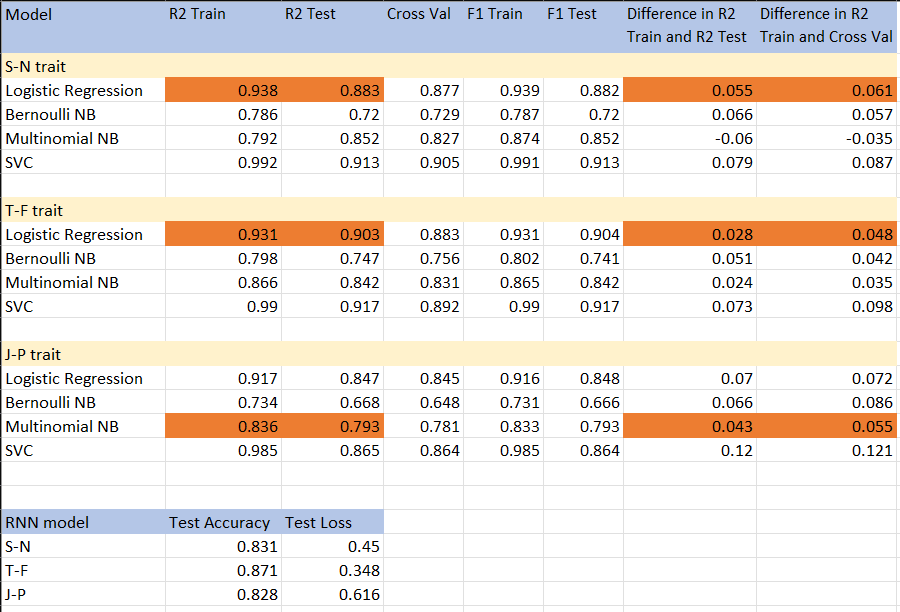

(a) Fit the chosen models onto the respective training datas

In [46]:
# Instantiate model and fit data in
model_sn = LogisticRegression()
model_sn.fit(X_train_sn_tvec, y_train_sn)

# Checking if the R2 test scores coincide with the classification report (sanity check)
model_sn.score(X_test_sn_tvec, y_test_sn)

0.8833333333333333

In [47]:
# Instantiate model and fit data in
model_tf = LogisticRegression()
model_tf.fit(X_train_tf_tvec, y_train_tf)

# Checking if the R2 test scores coincide with the classification report (sanity check)
model_tf.score(X_test_tf_tvec, y_test_tf)

0.9033333333333333

In [48]:
# Instantiate model and fit data in
model_jp = MultinomialNB()
model_jp.fit(X_train_jp_tvec, y_train_jp)

# Checking if the R2 test scores coincide with the classification report (sanity check)
model_jp.score(X_test_jp_tvec, y_test_jp)

0.7933333333333333

(b) Saving models in .pkl files

In [49]:
# Saving models as .pkl files

joblib.dump(model_sn, "./pkl_files/model_sn.pkl")
joblib.dump(model_tf, "./pkl_files/model_tf.pkl")
joblib.dump(model_jp, "./pkl_files/model_jp.pkl")

['./pkl_files/model_jp.pkl']

**Summary:**

The .pkl files will be used in Notebook 5 where we will import it in and use the Linkedin dataset to predict the MBTI model and provide a recommendation based on a user's text input.